**Projet de traitement et d'analyse de données volumineuse. **

Objectif du projet
Mettre en place un pipeline d’analyse et de nettoyage de données massives en environnement cloud (Google Colab), capable de :

* Charger rapidement des données volumineuses

* Optimiser les temps de traitement avec Dask

* Réaliser une analyse exploratoire et un nettoyage de qualité



Installation des outils nécessaires

In [29]:
!pip install dask[complete] --quiet

Téléverser ton fichier CSV dans Google Colab

Importer les modules nécessaires

In [30]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import time

Charger le dataset de manière efficace avec Dask

In [32]:
# Lecture du CSV avec encodage adapté et gestion des types manquants
df = dd.read_csv('DataCoSupplyChainDataset.csv', encoding='ISO-8859-1', assume_missing=True)

Sélectionner les colonnes pertinentes

In [33]:
colonnes_utiles = [
    'Days for shipping (real)', 'Days for shipment (scheduled)', 'Benefit per order',
    'Sales per customer', 'Delivery Status', 'Late_delivery_risk', 'Category Name',
    'Customer City', 'Order Zipcode', 'Product Name', 'Product Price',
    'shipping date (DateOrders)', 'Shipping Mode'
]

df_clean = df[colonnes_utiles]

Convertir les dates au bon format

In [34]:
df_clean['shipping date (DateOrders)'] = dd.to_datetime(df_clean['shipping date (DateOrders)'], errors='coerce')

Nettoyage basique

In [35]:
# Comptage des valeurs manquantes
missing = df_clean.isnull().sum().compute()
print("Valeurs manquantes par colonne :\n", missing)

# Suppression des lignes avec plus de 50% de données manquantes
threshold = int(len(colonnes_utiles) * 0.5)
df_clean = df_clean.dropna(thresh=threshold)

Valeurs manquantes par colonne :
 Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Name                         0
Customer City                         0
Order Zipcode                    155679
Product Name                          0
Product Price                         0
shipping date (DateOrders)            0
Shipping Mode                         0
dtype: int64


Analyse exploratoire simple

In [36]:
# Délai moyen réel vs prévu
print("Délai moyen réel (jours) :", df_clean['Days for shipping (real)'].mean().compute())
print("Délai moyen prévu (jours) :", df_clean['Days for shipment (scheduled)'].mean().compute())

Délai moyen réel (jours) : 3.4976539865609713
Délai moyen prévu (jours) : 2.931846509231715


In [37]:
# Bénéfice moyen par catégorie
print(df_clean.groupby('Category Name')['Benefit per order'].mean().compute())

Category Name
Accessories               9.350292
As Seen on  TV!          10.506323
Baby                      7.367295
Baseball & Softball      20.193244
Basketball               27.547313
Books                     2.180272
Boxing & MMA             20.428771
CDs                       1.416421
Cameras                  51.165203
Camping & Hiking         31.135230
Cardio Equipment         30.672788
Children's Clothing      41.684202
Cleats                   20.147323
Computers               157.594593
Consumer Electronics     30.680742
Crafts                   52.750351
DVDs                     13.779358
Electronics              12.956711
Fishing                  43.649106
Fitness Accessories      17.017443
Garden                   69.097128
Girls' Apparel           14.395146
Golf Apparel              7.928141
Golf Bags & Carts        29.673279
Golf Balls                5.656047
Golf Gloves              12.126626
Golf Shoes               23.675706
Health and Beauty        26.225497
Hockey

In [38]:
# Comptage des modes de livraison
print(df_clean['Shipping Mode'].value_counts().compute())

Shipping Mode
First Class        27814
Same Day            9737
Second Class       35216
Standard Class    107752
Name: count, dtype: int64[pyarrow]


In [39]:
# Nombre de livraisons en retard
print("Livraisons en retard :", df_clean[df_clean['Late_delivery_risk'] == 1].shape[0].compute())

Livraisons en retard : 98977


Visualisations (avec un échantillon 5% des données)

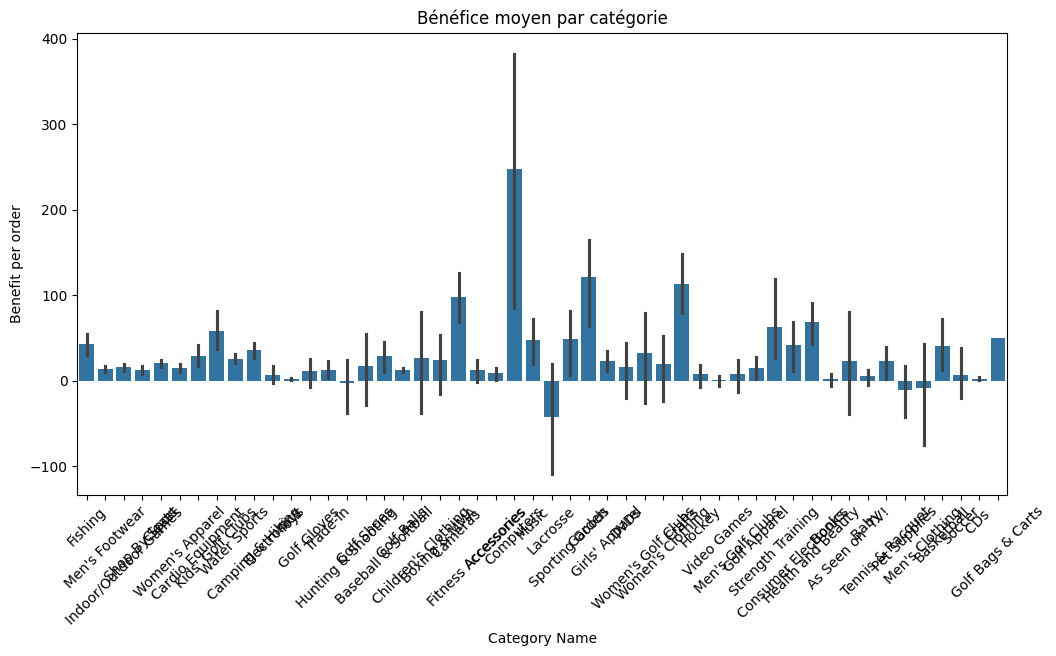

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

sample = df_clean.sample(frac=0.05).compute()

# Bénéfice moyen par catégorie
plt.figure(figsize=(12,6))
sns.barplot(x='Category Name', y='Benefit per order', data=sample)
plt.xticks(rotation=45)
plt.title('Bénéfice moyen par catégorie')
plt.show()

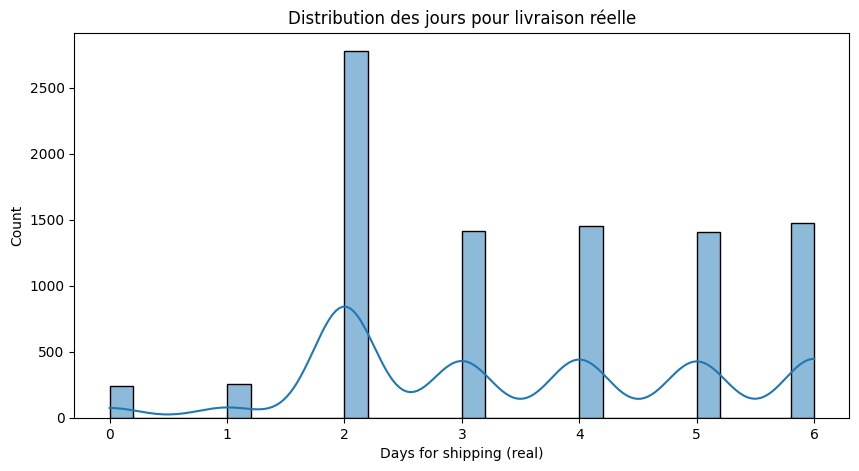

In [42]:
# Distribution des jours de livraison réelle
plt.figure(figsize=(10,5))
sns.histplot(sample['Days for shipping (real)'], bins=30, kde=True)
plt.title('Distribution des jours pour livraison réelle')
plt.show()

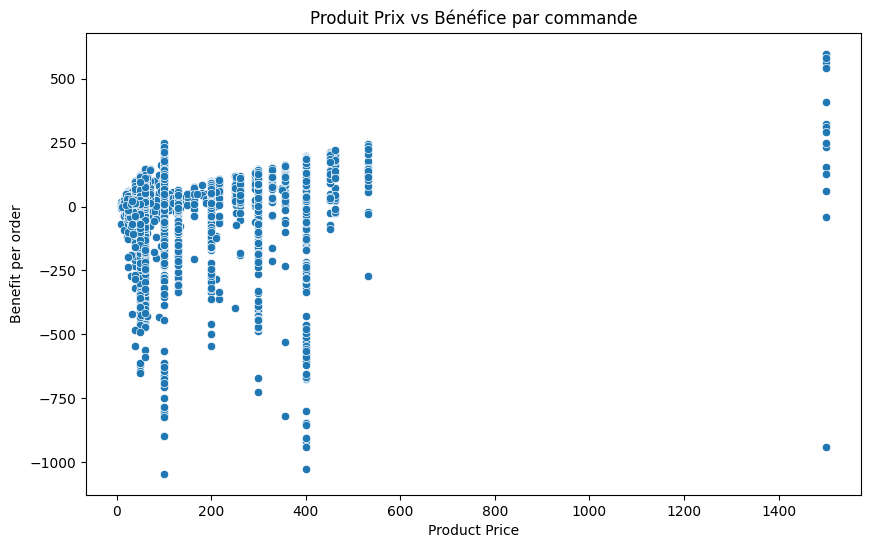

In [43]:
# Relation Produit Prix vs Bénéfice
plt.figure(figsize=(10,6))
sns.scatterplot(x='Product Price', y='Benefit per order', data=sample)
plt.title('Produit Prix vs Bénéfice par commande')
plt.show()

Exporter un échantillon nettoyé

In [45]:
df_clean_sample = df_clean.sample(frac=0.1).compute()
df_clean_sample.to_csv('clean_supply_chain_sample.csv', index=False)
df_clean_sample

,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Name,Customer City,Order Zipcode,Product Name,Product Price,shipping date (DateOrders),Shipping Mode
66510,2.0,2.0,-43.500000,174.000000,Shipping on time,0.0,Women's Apparel,Des Plaines,NaN,Nike Men's Dri-FIT Victory Golf Polo,50.000000,2016-02-25 03:37:00,Second Class
6592,5.0,4.0,-99.230003,141.750000,Late delivery,1.0,Women's Apparel,Caguas,NaN,Nike Men's Dri-FIT Victory Golf Polo,50.000000,2015-09-10 23:39:00,Standard Class
147317,5.0,2.0,123.940002,395.980011,Late delivery,1.0,Fishing,Caguas,NaN,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,2016-10-05 20:07:00,Second Class
80026,6.0,4.0,59.150002,188.990005,Late delivery,1.0,Water Sports,Caguas,77070.0,Pelican Sunstream 100 Kayak,199.990005,2016-04-14 05:50:00,Standard Class
31211,2.0,4.0,-14.290000,226.759995,Shipping canceled,0.0,Cleats,Caguas,NaN,Perfect Fitness Perfect Rip Deck,59.990002,2016-02-05 01:53:00,Standard Class
...,...,...,...,...,...,...,...,...,...,...,...,...,...
160025,5.0,4.0,193.990005,387.980011,Late delivery,1.0,Fishing,Caguas,NaN,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,2015-01-11 07:10:00,Standard Class
28334,2.0,1.0,46.080002,383.980011,Late delivery,1.0,Fishing,Aurora,NaN,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,2015-02-20 14:17:00,First Class
176428,2.0,1.0,92.160004,192.000000,Late delivery,1.0,Women's Apparel,Caguas,75104.0,Nike Men's Dri-FIT Victory Golf Polo,50.000000,2016-06-23 13:26:00,First Class
169597,5.0,2.0,45.500000,181.979996,Late delivery,1.0,Cardio Equipment,Stockbridge,NaN,Nike Men's Free 5.0+ Running Shoe,99.989998,2015-05-13 22:04:00,Second Class


Télécharger le fichier nettoyé (depuis Colab)

In [46]:
from google.colab import files
files.download('/content/DataCoSupplyChainDataset.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>